## TASK 1: Data Cleaning
Objective: Ensure the dataset is clean and ready for analysis.

#### Step 1: Import Libraries and Load the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA

# Load the stock price data, parsing dates and setting 'Date' as index
df_raw = pd.read_csv('dataset.csv', parse_dates=['Date'], index_col='Date')

# Preview the first few rows to inspect the structure
print(df_raw.head())

                 AAPL        DIS        FMC         KO        ORA
Date                                                             
2013-01-02  16.687346  45.887768  41.757179  25.820656  18.436375
2013-01-03  16.476715  45.986546  41.398796  25.820656  18.234386
2013-01-04  16.017761  46.866585  41.553398  25.861870  18.326195
2013-01-07  15.923531  45.771023  42.129639  25.614639  18.004848
2013-01-08  15.966393  45.582443  42.452915  25.436098  18.179296


#### Step 2: Check for Missing Data

In [10]:
# Check for missing valuess in each column
missing = df_raw.isnull().sum()
print('Missing values in each column:')
print(missing)

Missing values in each column:
AAPL    31
DIS     32
FMC     41
KO      47
ORA     37
dtype: int64


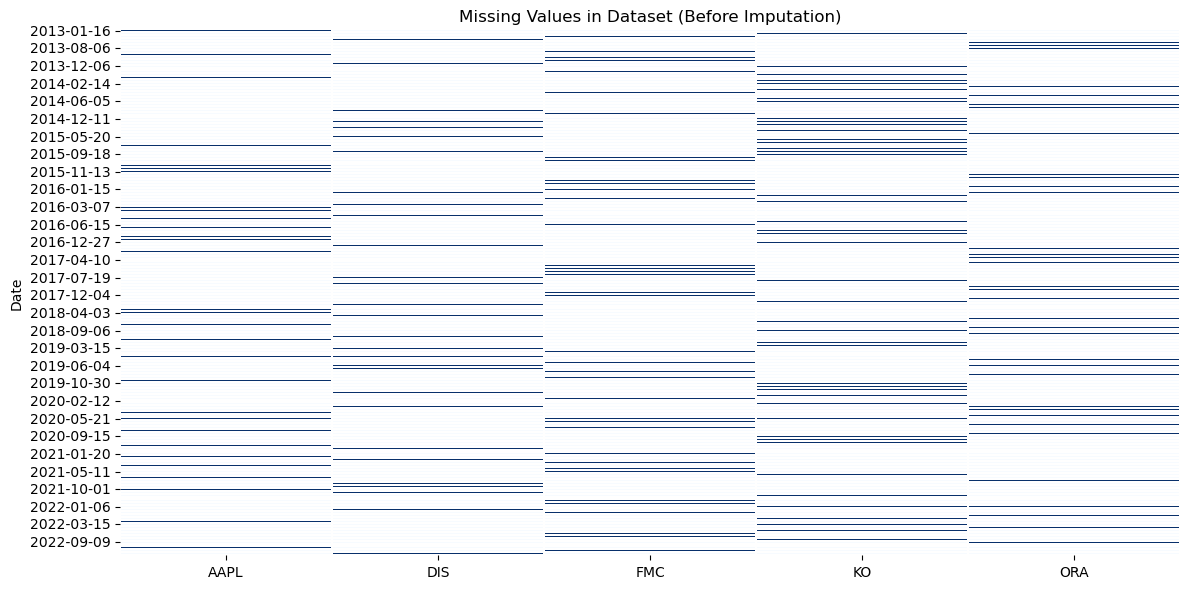

In [11]:
# Filter only rows with missing data
missing_rows = df_raw[df_raw.isnull().any(axis=1)]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(missing_rows.isnull(),
            cmap='Blues',
            cbar=False,
            linewidths=0.1)

# Clean y-axis labels: strip time portion
ax = plt.gca()
yticklabels = ax.get_yticklabels()
ax.set_yticklabels([label.get_text().split('T')[0] for label in yticklabels])

# Set title and labels
plt.title('Missing Values in Dataset (Before Imputation)')
plt.xlabel('')
plt.ylabel('Date')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Step 3: Handle Missing Data

In [12]:
# Impute missing values: forward fill first to maintain continuity, then backward fill any remaining gaps
df_clean = df_raw.ffill().bfill()

# Verify that there are no missing values after imputation
print('Missing after fill:', df_clean.isnull().sum().sum())

Missing after fill: 0


#### Step 4: Summary Statistics and Visual Confirmation

              AAPL          DIS          FMC           KO          ORA
count  2518.000000  2518.000000  2518.000000  2518.000000  2518.000000
mean     60.000285   106.956558    65.102529    38.432587    51.913753
std      48.728045    32.072616    25.724700     9.233892    21.053852
min      11.939036    45.420811    23.805256    25.298744    17.949759
25%      24.419836    89.537548    42.973635    30.818038    33.623310
50%      39.100491   101.592751    61.217964    35.964373    53.463560
75%      89.185068   123.442537    87.050566    45.221765    67.815140
max     179.076599   199.446121   128.343582    60.956150   122.894501


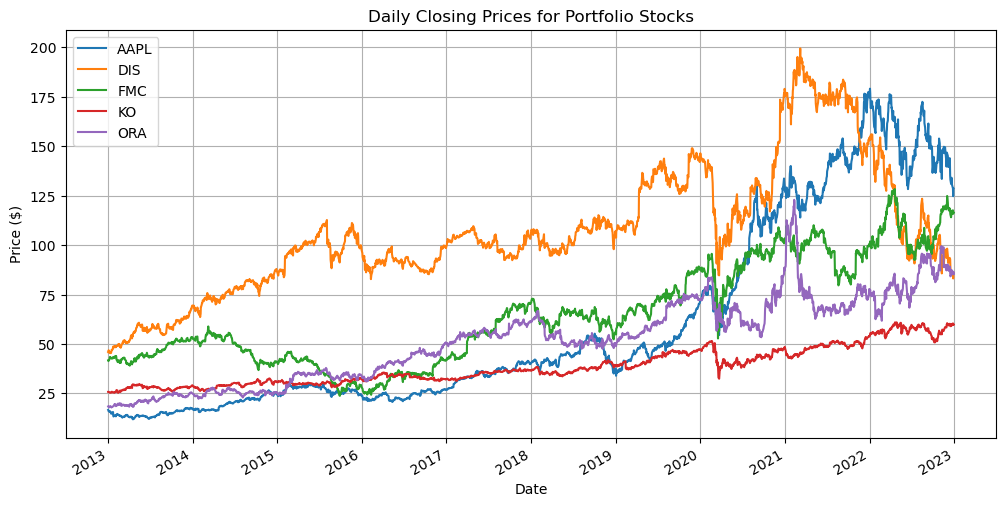

In [13]:
# Generate summary statistics to check the dataset post-cleaning
print(df_clean.describe())

# Plot daily closing price for each stock to visually verify data continuity
df_clean.plot(figsize=(12, 6), title='Daily Closing Prices for Portfolio Stocks')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

## TASK 2: Portfolio Analysis using Mean-Variance Optimisation (MVO)
Objective: Evaluate the investor’s portfolio using historical data and optimize it using the efficient frontier.

#### Step 1: Calculate Daily & Annualised Returns

In [14]:
# Calculate daily returns
returns = df_clean.pct_change().dropna()

# Calculate annualised mean returns and volatilities (assuming 252 trading days per year)
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * (252 ** 0.5)

# Create a DataFrame to summarize the annual returns and volatilities
summary = pd.DataFrame({
  'Annual Return (%)': annual_returns * 100,
  'Annual Volatility (%)': annual_volatility * 100
  })

# Display summary
print(summary)

      Annual Return (%)  Annual Volatility (%)
AAPL          24.660577              28.990582
DIS            9.778552              26.523078
FMC           14.795351              30.060649
KO            10.049231              18.029326
ORA           20.340402              31.635394


#### Step 2: Plot Risk vs Return (Basic Visualisation Before EF)

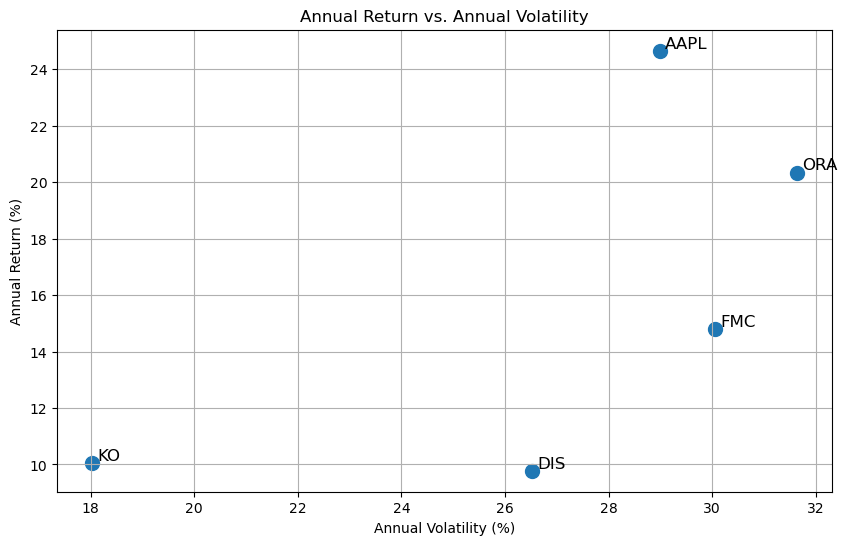

In [15]:
# Plot risk vs return for individual individual stocks
plt.figure(figsize=(10, 6))
plt.scatter(summary['Annual Volatility (%)'], summary['Annual Return (%)'], s=100)

# Annotate each stock
for i in summary.index:
  plt.text(summary.loc[i, 'Annual Volatility (%)'] + 0.1,
           summary.loc[i, 'Annual Return (%)'] + 0.1,
           i,
           fontsize=12)

# Plot annual return vs annual volatility
plt.title('Annual Return vs. Annual Volatility')
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid(True)
plt.show()

#### Step 3: Monte Carlo Simulation for Portfolio Optimisation

In [16]:
np.random.seed(42)# Ensure reproducibility

n_portfolios = 10000
n_assets = len(returns.columns)
results = np.zeros((n_portfolios, 3)) # Columns: return, Risk, and Sharpe Ratio
weights_record = []

# Define necessary statistics
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
rf = 0.05 # 5% assumed annual risk-free rate

# Generate random portfolios
for i in range(n_portfolios):
  weights = np.random.random(n_assets)
  weights /= np.sum(weights) # Normalise weights to sum to 1
  weights_record.append(weights)

  # Portfolio return and risk
  portfolio_return = np.dot(weights, mean_daily_returns) * 252
  portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

  # Sharpe Ratio calculation
  sharpe_ratio = (portfolio_return - rf) / portfolio_std_dev

  results[i, 0] = portfolio_return
  results[i, 1] = portfolio_std_dev
  results[i, 2] = sharpe_ratio

# Store results in a DataFrame
results_frame = pd.DataFrame(results, columns=['Return', 'Risk', 'Sharpe Ratio'])

#### Step 4: Identify Optimal Portfolios

In [17]:
# Tangency Portfolio: Maximises Sharpe Ratio
max_sharpe_idx = results_frame['Sharpe Ratio'].idxmax()
tangency_weights = weights_record[max_sharpe_idx]

# Max Utility Portfolio: Maximises U = E(R) - 0.5 * A * σp^2, with A = 5
A = 5
results_frame['Utility'] = results_frame['Return'] - (A / 2) * results_frame['Risk'] ** 2
max_utility_idx = results_frame['Utility'].idxmax()
utility_weights = weights_record[max_utility_idx]

# Display optimal portfolio weights
print('Tangency Portfolio Weights:')
print(dict(zip(returns.columns, np.round(tangency_weights, 4))))

print('Max Utility Portfolio Weights:')
print(dict(zip(returns.columns, np.round(utility_weights, 4))))

Tangency Portfolio Weights:
{'AAPL': 0.5627, 'DIS': 0.0286, 'FMC': 0.0202, 'KO': 0.0622, 'ORA': 0.3263}
Max Utility Portfolio Weights:
{'AAPL': 0.4203, 'DIS': 0.022, 'FMC': 0.0662, 'KO': 0.2373, 'ORA': 0.2542}


#### Step 5: Plot Efficient Frontier

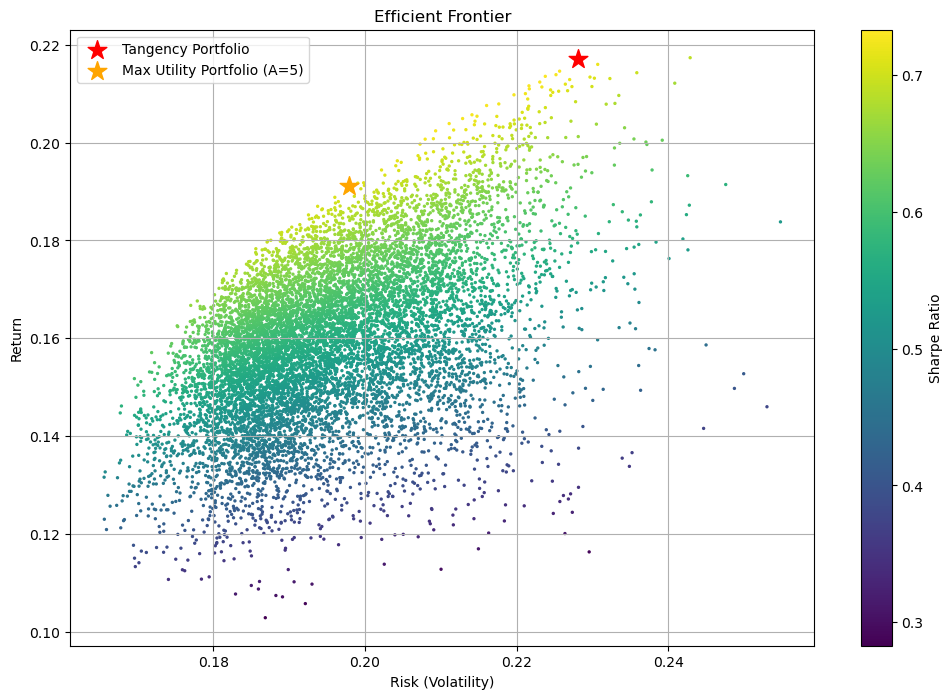

In [18]:
# Plot Efficient Frontier
plt.figure(figsize=(12,8))
plt.scatter(results_frame['Risk'], results_frame['Return'], c=results_frame['Sharpe Ratio'], cmap='viridis', s=2)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Return')
plt.title('Efficient Frontier')

# Highlight Tangency and Max Utility Portfolios
plt.scatter(results_frame.loc[max_sharpe_idx, 'Risk'], results_frame.loc[max_sharpe_idx, 'Return'], color='red', marker='*', s=200, label='Tangency Portfolio')
plt.scatter(results_frame.loc[max_utility_idx, 'Risk'], results_frame.loc[max_utility_idx, 'Return'], color='orange', marker='*', s=200, label='Max Utility Portfolio (A=5)')

plt.legend()
plt.grid(True)
plt.show()

## TASK 3: Time Series Prediction
Objective: Predict potential changes in future stock return and volatility using time series or machine learning models.

#### Step 1: Log Returns for AAPL

<Axes: title={'center': 'AAPL Daily Log Returns'}, xlabel='Date'>

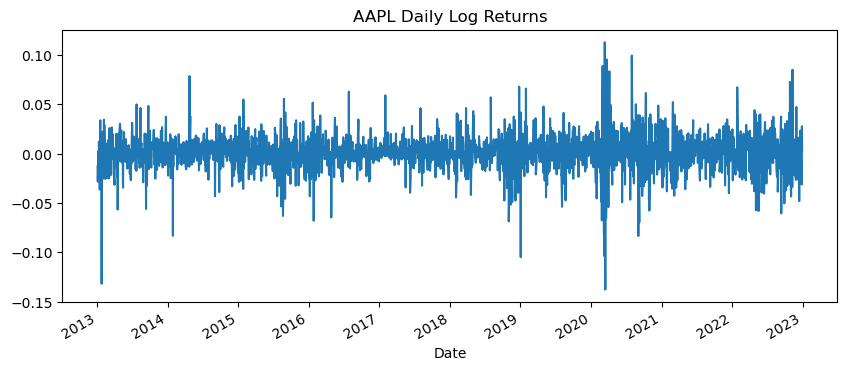

In [19]:
# Use log returns for stationarity testing
aapl_log_returns = np.log(df_clean['AAPL'] / df_clean['AAPL'].shift(1)).dropna()

# Visualise daily log returns
aapl_log_returns.plot(figsize=(10,4), title='AAPL Daily Log Returns')

#### Step 2: Check Stationarity with ADF Test

In [20]:
# ADF test for stationarity
result = adfuller(aapl_log_returns)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.259634784978424
p-value: 3.5766549079917105e-29


#### Step 3: Fit ARIMA Model (Return Forecasting) for AAPL

In [21]:
import warnings
warnings.filterwarnings('ignore')

# Automated ARIMA (p,0,q) model selection using AIC minimisation
aic_values = {}
for p in range(4):
    for q in range(4):
        try:
            model = sm.tsa.ARIMA(aapl_log_returns, order=(p,0,q)).fit()
            aic_values[(p,q)] = model.aic
        except:
            continue

# Find best (p,q)
best_order = min(aic_values, key=aic_values.get)
print(f'Best ARIMA(p,0,q) = {best_order} with AIC = {aic_values[best_order]:.2f}')

Best ARIMA(p,0,q) = (1, 0) with AIC = -13004.73


Predicted log returns for the next 30 days using the ARIMA model.

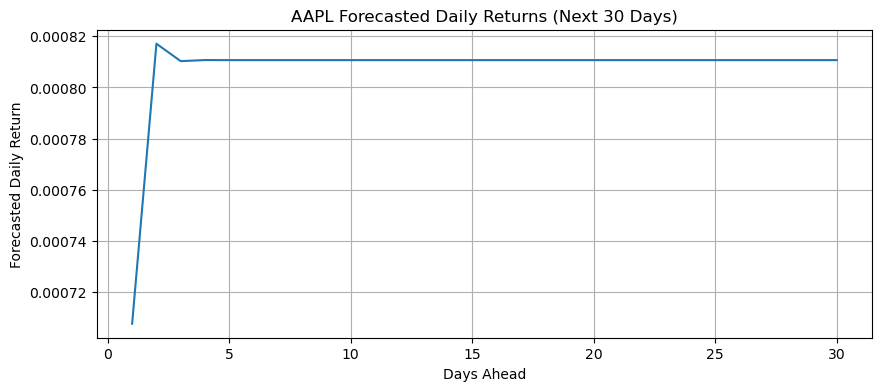

In [22]:
# Fit ARIMA model with optimal parameters
arima_model = sm.tsa.ARIMA(aapl_log_returns, order=(best_order[0], 0, best_order[1])).fit()
forecast_returns = arima_model.forecast(steps=30) # forecast next 30 days

# Generate X-axis for forecast (Day 1 to Day 30)
days = list(range(1, 31))

# Plot the forecasted returns
plt.figure(figsize=(10, 4))
plt.plot(days, forecast_returns)
plt.title("AAPL Forecasted Daily Returns (Next 30 Days)")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Daily Return")
plt.grid(True)
plt.show()

#### Step 4: Fit GARCH Model (Volatility Forecasting) for AAPL

Daily volatility from the GARCH(1,1) model over 30 days.

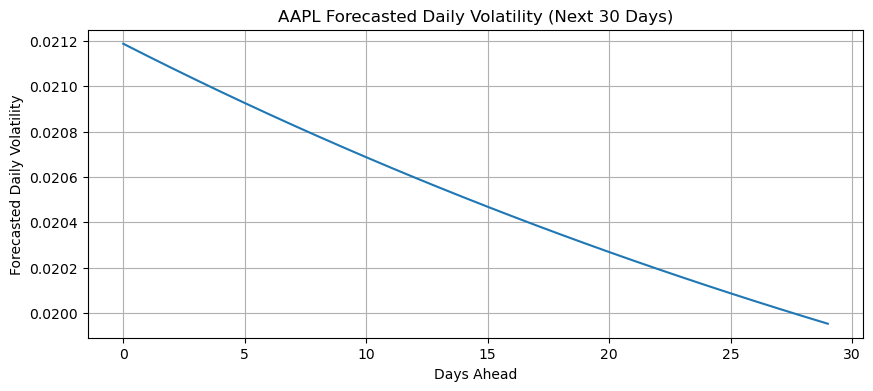

In [23]:
# Fit GARCH(1,1) model to forecast volatility
garch_model = arch_model(aapl_log_returns, vol='GARCH', p=1, q=1)
garch_fitted = garch_model.fit(disp='off')

# Forecast volatility for next 30 days
garch_forecast = garch_fitted.forecast(horizon=30)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# Plot the forecasted volatility
plt.figure(figsize=(10,4))
plt.plot(volatility_forecast)
plt.title('AAPL Forecasted Daily Volatility (Next 30 Days)')
plt.ylabel('Forecasted Daily Volatility')
plt.xlabel('Days Ahead')
plt.grid(True)
plt.show()

100 Monte Carlo simulated paths using ARIMA mean + GARCH volatility.

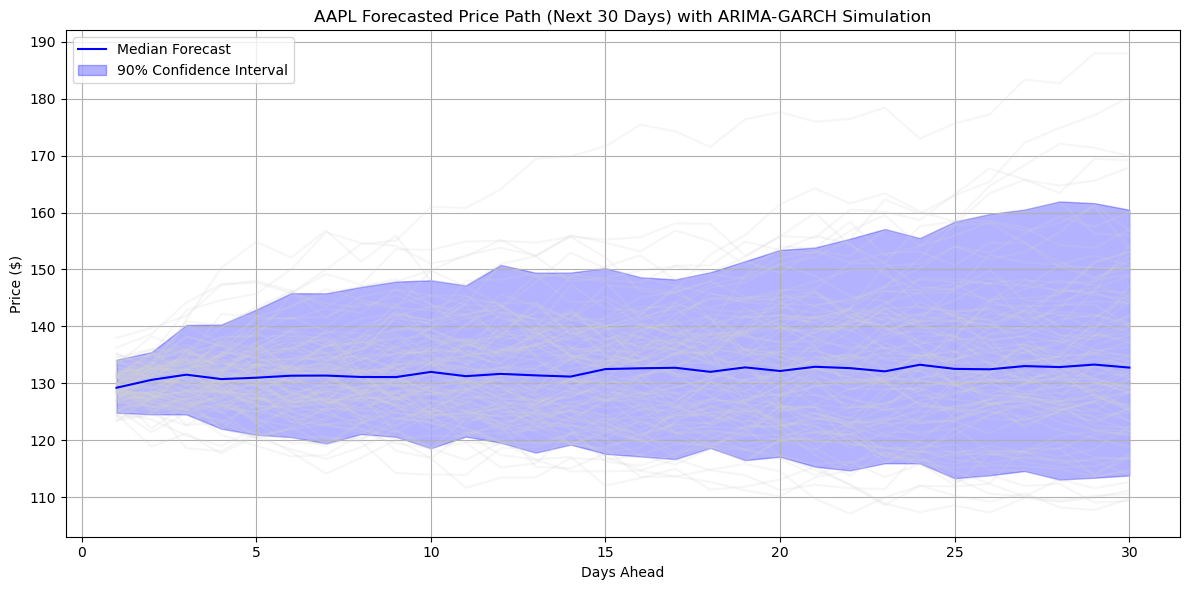

In [24]:
# Parameters
n_simulations = 100
n_days = 30
mean_returns = forecast_returns.values  # from ARIMA
daily_volatility = volatility_forecast  # from GARCH
last_price = df_clean['AAPL'].iloc[-1]

# Monte Carlo simulation of price paths
simulated_prices = np.zeros((n_simulations, n_days))
for i in range(n_simulations):
    simulated_log_returns = np.random.normal(loc=mean_returns, scale=daily_volatility)
    cumulative_log_returns = np.cumsum(simulated_log_returns)
    simulated_prices[i] = last_price * np.exp(cumulative_log_returns)

# Compute median and confidence bands
price_median = np.median(simulated_prices, axis=0)
price_p5 = np.percentile(simulated_prices, 5, axis=0)
price_p95 = np.percentile(simulated_prices, 95, axis=0)

# Plotting
plt.figure(figsize=(12, 6))
# Plot all simulation paths (optional, comment out if too busy)
for i in range(n_simulations):
    plt.plot(range(1, n_days+1), simulated_prices[i], color='lightgray', alpha=0.2)

# Plot median and confidence bands
plt.plot(range(1, n_days+1), price_median, color='blue', label='Median Forecast')
plt.fill_between(range(1, n_days+1), price_p5, price_p95, color='blue', alpha=0.3, label='90% Confidence Interval')

# Final formatting
plt.title('AAPL Forecasted Price Path (Next 30 Days) with ARIMA-GARCH Simulation')
plt.xlabel('Days Ahead')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

100 Monte Carlo simulated paths using ARIMA mean + GARCH volatility, overlaid on recent historical prices.

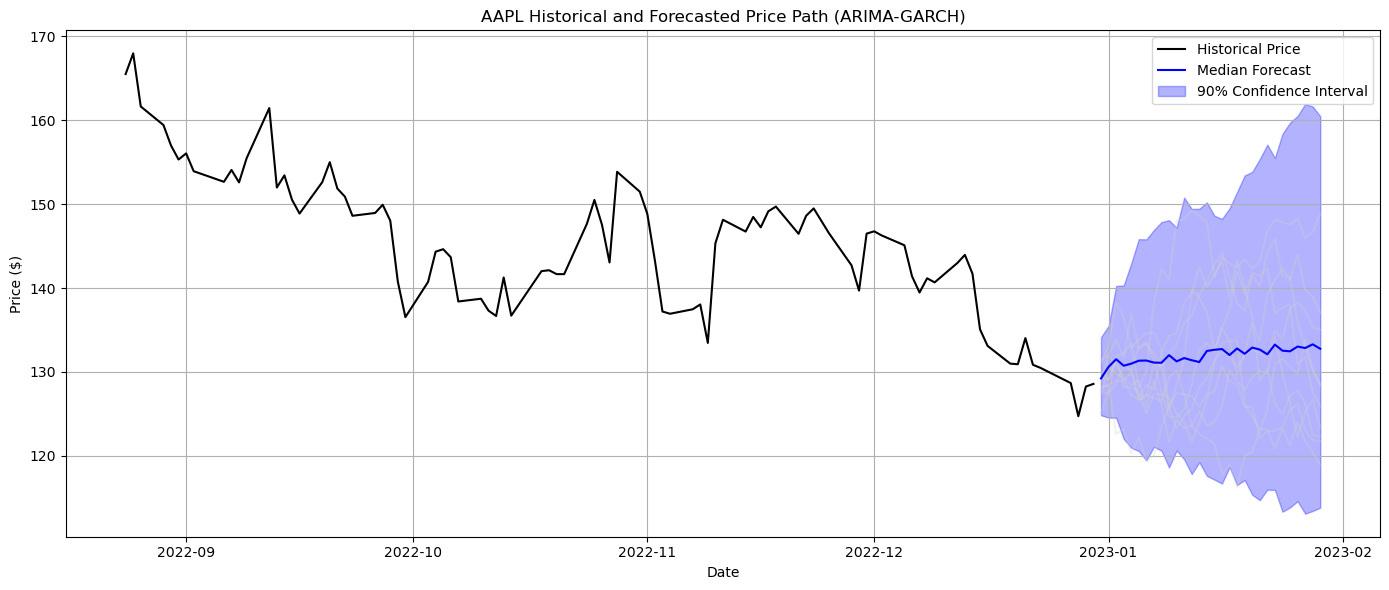

In [25]:
# Select last N days of historical prices
history_days = 90
historical_prices = df_clean['AAPL'].dropna().iloc[-history_days:]
historical_dates = historical_prices.index

# Create forecast date range starting from the day after the last price
forecast_dates = pd.date_range(start=historical_dates[-1] + pd.Timedelta(days=1), periods=n_days)

# Combine historical + forecast dates
full_dates = list(historical_dates) + list(forecast_dates)

# Combine historical prices and forecast median
combined_median = np.concatenate([historical_prices.values, price_median])
combined_p5 = np.concatenate([np.full_like(historical_prices.values, np.nan), price_p5])
combined_p95 = np.concatenate([np.full_like(historical_prices.values, np.nan), price_p95])

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(historical_dates, historical_prices, label='Historical Price', color='black')

# Optional: Plot a few simulated paths
for i in range(10):  # fewer lines for readability
    plt.plot(forecast_dates, simulated_prices[i], color='lightgray', alpha=0.3)

# Plot median forecast and confidence interval
plt.plot(forecast_dates, price_median, color='blue', label='Median Forecast')
plt.fill_between(forecast_dates, price_p5, price_p95, color='blue', alpha=0.3, label='90% Confidence Interval')

# Final styling
plt.title('AAPL Historical and Forecasted Price Path (ARIMA-GARCH)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Step 5: Batch Summary for Remaining Stocks (DIS, FMC, KO, ORA)

In [26]:
# Define function to forecast stock returns and volatility
def forecast_stock(ticker):
    '''
    Forecast the mean daily return and mean daily volatility for a given stock
    ticker over a 30-day horizon using ARIMA and GARCH models.

    Args:
        ticker (str): Stock ticker symbol (e.g., APPL, KO).

    Returns:
        tuple: Mean foreqast daily return (%) and mean forecast daily volatility (%).
    '''
    # Calculate daily log returns
    log_ret = np.log(df_clean[ticker] / df_clean[ticker].shift(1)).dropna()

    # Select ARIMA(p, 0, q) model based on AIC minimisation
    best_aic = np.inf
    best_order = None
    for p in range(3):
        for q in range(3):
            try:
                model = ARIMA(log_ret, order=(p,0,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,0,q)
            except:
                continue

    # Fit the best ARIMA model and forecast mean daily return
    arima_model = ARIMA(log_ret, order=best_order).fit()
    return_forecast = arima_model.forecast(steps=30).mean()

    # Fit GARCH(1,1) model and forecast mean daily volatility
    garch = arch_model(log_ret, vol='GARCH', p=1, q=1)
    garch_fit = garch.fit(disp='off')
    vol_forecast = np.sqrt(garch_fit.forecast(horizon=30).variance.values[-1, :]).mean()

    return return_forecast, vol_forecast

In [27]:
# Run batch forcasting for remaining stocks
tickers = ['AAPL', 'DIS', 'FMC', 'KO', 'ORA']
forecast_summary = {}

for ticker in tickers:
    mean_ret, mean_vol = forecast_stock(ticker)
    forecast_summary[ticker] = {
        'Mean Daily Return (%)': mean_ret * 100,
        'Mean Daily Volatility (%)': mean_vol * 100
    }

# Display forecast results
forecast_df = pd.DataFrame(forecast_summary).T
print(forecast_df)

      Mean Daily Return (%)  Mean Daily Volatility (%)
AAPL               0.080745                   2.051824
DIS                0.025497                   2.189063
FMC                0.041540                   1.768295
KO                 0.033227                   1.024165
ORA                0.065138                   1.910622


## TASK 4: Factor Exposure Analysis Using the Fama-French 3-Factor Model
Objective: Determine if the portfolio’s performance is driven by exposure to factor risks such as size, value, etc. The Fama-French 3-Factor data are available on blackboard (ff3 factor.csv). 

#### Step 1: Load and Prepare FF3 Data

In [28]:
# Load FF3 CSV
ff3 = pd.read_csv('ff3 factor.csv', parse_dates=['Date'], index_col='Date')

# Ensure returns match frequency
ff3 = ff3.loc[returns.index]  # align with stock return index

# Convert percentages to decimals
ff3 = ff3 / 100

#### Step 2: Calculate Excess Returns

In [29]:
# Calculate daily log excess returns
aapl_excess = np.log(df_clean['AAPL'] / df_clean['AAPL'].shift(1)).dropna() - ff3['RF']

#### Step 3: Run OLS Regression

In [30]:
# Prepare independent variables: Mkt-RF, SMB, HML
X = ff3[['Mkt-RF', 'SMB', 'HML']]

# Add constant for intercept
X = sm.add_constant(X)

# Prepare dependent variable: AAPL excess returns
y = aapl_excess

# Fit Ordinary Least Squares (OLS) regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     937.5
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        11:35:10   Log-Likelihood:                 7445.6
No. Observations:                2517   AIC:                        -1.488e+04
Df Residuals:                    2513   BIC:                        -1.486e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.848      0.3

#### Step 4: Summary Table for Remaining Stocks

In [31]:
def ff3_regression(ticker):
    '''
    Perform Fama-French 3-factor regression for a given stock ticker.

    Args:
        ticker (str): Stock ticker symbol (e.g., APPL, KO).

    Returns:
        dict: Regression results including coefficients and R-squared.
    '''
    # Calculate daily excess returns for the stock
    excess_ret = np.log(df_clean[ticker] / df_clean[ticker].shift(1)).dropna() - ff3['RF']

    # Prepare independent variables: Mkt-RF, SMB, HML
    X = sm.add_constant(ff3[['Mkt-RF', 'SMB', 'HML']])

    # Fit OLS regression
    model = sm.OLS(excess_ret, X).fit()

    # Return coefficients and R-squared
    return {
        'Intercept': model.params['const'],
        'Mkt-RF': model.params['Mkt-RF'],
        'SMB': model.params['SMB'],
        'HML': model.params['HML'],
        'R-squared': model.rsquared
    }

In [32]:
# Apply FF3 regression to each stock in the portfolio
factor_summary = pd.DataFrame({ticker: ff3_regression(ticker) for ticker in ['AAPL', 'DIS', 'FMC', 'KO', 'ORA']}).T
print(factor_summary)

      Intercept    Mkt-RF       SMB       HML  R-squared
AAPL   0.000213  1.139133 -0.319203 -0.409063   0.528122
DIS   -0.000256  0.992942  0.036321  0.213342   0.462982
FMC   -0.000116  1.049131  0.197219  0.429662   0.437281
KO    -0.000002  0.619519 -0.412613  0.217483   0.394254
ORA    0.000221  0.778026  0.566169  0.108453   0.256442


## TASK 5: Risk and Performance Evaluation
Objective: Evaluate the risk and performance of the tangency portfolio.

In [34]:
# Define tangency portfolio weights obtained from MVO results
tangency_weights = np.array([0.5627, 0.0286, 0.0202, 0.0622, 0.3263])  # AAPL, DIS, FMC, KO, ORA

#### Step 1: Daily Portfolio Returns (Tangency & Equal Weighted)

In [35]:
# Use pre-calculated daily returns of each stock
daily_returns = returns

# Calculate daily returns of the tangency portfolio
tangency_ret = daily_returns.dot(tangency_weights)

# Calculate daily returns of the equally weighted portfolio
equal_weights = np.ones(len(returns.columns)) / len(returns.columns)
equal_ret = daily_returns.dot(equal_weights)

#### Step 2: VaR and Expected Shortfall (95% confidence)

In [36]:
# Set confidence level for VaR and ES
confidence_level = 0.95

# Calculate tangency portfolio VaR and ES
var_t = np.percentile(tangency_ret, 100 * (1 - confidence_level))
es_t = tangency_ret[tangency_ret <= var_t].mean()

# Calculate equal-weighted portfolio VaR and ES
var_e = np.percentile(equal_ret, 100 * (1 - confidence_level))
es_e = equal_ret[equal_ret <= var_e].mean()

# Print VaR and ES results for both portfolios
print(f'Tangency VaR (95%): {var_t:.4f}')
print(f'Tangency ES  (95%): {es_t:.4f}')
print(f'Equal-Wtd VaR (95%): {var_e:.4f}')
print(f'Equal-Wtd ES  (95%): {es_e:.4f}')

Tangency VaR (95%): -0.0228
Tangency ES  (95%): -0.0334
Equal-Wtd VaR (95%): -0.0172
Equal-Wtd ES  (95%): -0.0277


#### Step 3: Performance Metrics and Stress Testing

In [37]:
# Sharpe Ratio
def sharpe_ratio(r, rf=0.05, periods=252):
    '''
    Calculate annualised Sharpe Ratio of a portfolio.

    Args:
        r (Series): Daily returns of the portfolio.
        rf (float, optional): Annual risk-free rate. Defaults to 0.05 (5%).
        periods (int, optional): Number of trading periods per year. Defaults to 252.

    Returns:
        float: Annualised Sharpe Ratio.
    '''
    return (r.mean() * periods - rf) / (r.std() * np.sqrt(periods))

# Sortino Ratio
def sortino_ratio(r, rf=0.05, periods=252):
    '''
    Calculate annualised Sortino Ratio of a portfolio.

    Args:
        r (Series): Daily returns of the portfolio.
        rf (float, optional): Annual risk-free rate. Defaults to 0.05 (5%).
        periods (int, optional): Number of trading periods per year. Defaults to 252.

    Returns:
        float: Annualised Sortino Ratio.
    '''
    downside = r[r < 0].std()
    return (r.mean() * periods - rf) / (downside * np.sqrt(periods))

In [38]:
# Calculate and display Sharpe and Sortino Ratios for both portfolios
print(f'Tangency Sharpe: {sharpe_ratio(tangency_ret):.2f}')
print(f'Equal-Wtd Sharpe: {sharpe_ratio(equal_ret):.2f}')
print(f'Tangency Sortino: {sortino_ratio(tangency_ret):.2f}')
print(f'Equal-Wtd Sortino: {sortino_ratio(equal_ret):.2f}')

Tangency Sharpe: 0.73
Equal-Wtd Sharpe: 0.58
Tangency Sortino: 1.00
Equal-Wtd Sortino: 0.75


Tangency Stress Test

In [39]:
# Simulate a -10% market shock
shock = -0.10

# Calculate the covariance matrix of asset returns
cov = returns.cov()

# Estimate the portfolio standard deviation based on tangency weights
# Then multiply by shock magnitude to estimate portfolio drop
shock_impact = tangency_weights.dot(cov.dot(tangency_weights))**0.5 * shock

# Display the estimated drop in portfolio value under the shock
print(f'Stress Test: Estimated drop in portfolio under -10% market shock = {shock_impact:.4f}')

Stress Test: Estimated drop in portfolio under -10% market shock = -0.0014


Max Utility Metrics and Stress Test

In [40]:
# Define Max Utility portfolio weights from report
utility_weights = np.array([0.4203, 0.0220, 0.0662, 0.2373, 0.2542])  # AAPL, DIS, FMC, KO, ORA

# Calculate daily returns of the Max Utility Portfolio
utility_ret = daily_returns.dot(utility_weights)

# Max Utility Portfolio Risk Metrics
var_u = np.percentile(utility_ret, 100 * (1 - confidence_level))
es_u = utility_ret[utility_ret <= var_u].mean()

# Max Utility Portfolio Performance Metrics
sharpe_u = sharpe_ratio(utility_ret)
sortino_u = sortino_ratio(utility_ret)

# Stress test for Max Utility Portfolio
shock_impact_u = utility_weights.dot(cov.dot(utility_weights))**0.5 * shock

# Print results
print(f'Max Utility VaR (95%): {var_u:.4f}')
print(f'Max Utility ES  (95%): {es_u:.4f}')
print(f'Max Utility Sharpe: {sharpe_u:.2f}')
print(f'Max Utility Sortino: {sortino_u:.2f}')
print(f'Stress Test (Max Utility): {shock_impact_u:.4f}')

Max Utility VaR (95%): -0.0191
Max Utility ES  (95%): -0.0292
Max Utility Sharpe: 0.71
Max Utility Sortino: 0.94
Stress Test (Max Utility): -0.0012


Equal-Weight Stress Test

In [42]:
# Equal-weighted portfolio stress test
shock = -0.10
equal_weights = np.ones(len(returns.columns)) / len(returns.columns)
cov = returns.cov()

shock_impact_equal = equal_weights.dot(cov.dot(equal_weights))**0.5 * shock
print(f'Stress Test (Equal-Weighted): {shock_impact_equal:.4f}')

Stress Test (Equal-Weighted): -0.0012


#### STEP 4: Monte Carlo Black Swan Simulation

Monte Carlo Stress Test Results for Tangency Portfolio:
Stress VaR (5%): -2.2693%
Stress Expected Shortfall (ES): -2.8447%


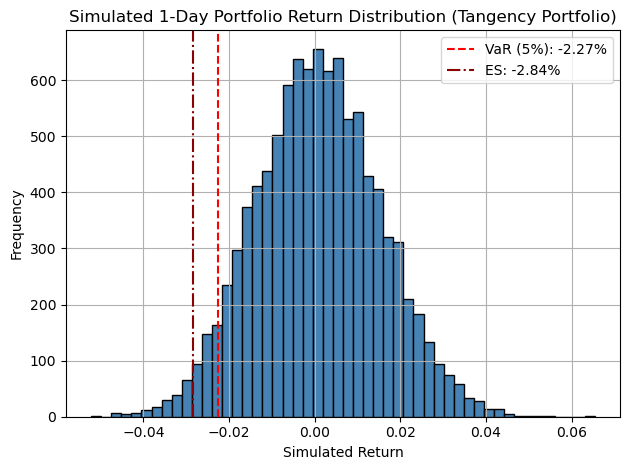

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Use your cleaned daily returns dataframe
daily_returns = returns  # already defined earlier in your notebook

# Tangency Portfolio weights
tangency_weights = np.array([0.5627, 0.0286, 0.0202, 0.0622, 0.3263])  # AAPL, DIS, FMC, KO, ORA

# Calculate mean and covariance of daily returns
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Number of simulations
n_simulations = 10000

# Simulate 1-day returns using multivariate normal distribution
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, n_simulations)

# Calculate portfolio returns for each simulation
simulated_portfolio_returns = simulated_returns.dot(tangency_weights)

# Compute VaR and Expected Shortfall (ES) at 5% level
stress_var = np.percentile(simulated_portfolio_returns, 5)
stress_es = simulated_portfolio_returns[simulated_portfolio_returns <= stress_var].mean()

print('Monte Carlo Stress Test Results for Tangency Portfolio:')
print(f'Stress VaR (5%): {stress_var:.4%}')
print(f'Stress Expected Shortfall (ES): {stress_es:.4%}')

# Plot distribution
plt.hist(simulated_portfolio_returns, bins=50, color='steelblue', edgecolor='black')
plt.axvline(stress_var, color='red', linestyle='--', label=f'VaR (5%): {stress_var:.2%}')
plt.axvline(stress_es, color='darkred', linestyle='-.', label=f'ES: {stress_es:.2%}')
plt.title('Simulated 1-Day Portfolio Return Distribution (Tangency Portfolio)')
plt.xlabel('Simulated Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()